In [2]:
import numpy as np 

In [3]:
def loadSimpData():
    datMat = np.matrix([[1., 2.1],
                [2., 1.1],
                [1.3, 1.],
                [1.,  1.],
                [2.,  1.]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat, classLabels

In [4]:
datMat, classLabels = loadSimpData()

In [5]:
print(datMat)

[[1.  2.1]
 [2.  1.1]
 [1.3 1. ]
 [1.  1. ]
 [2.  1. ]]


In [12]:
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    retArray = np.ones((dataMatrix.shape[0], 1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray

def bulidStump(dataArr, classLabels, D):
    dataMatrix = np.mat(dataArr)
    labelMat = np.mat(classLabels).T
    m, n = dataMatrix.shape 
    numSteps = 10.0
    bestStump = {}
    bestClassEst = np.mat(np.zeros((m,1)))
    minError = np.inf 
    for i in range(n):
        rangeMin = dataMatrix[:,i].min()
        rangeMax = dataMatrix[:,i].max()
        stepSize = (rangeMax - rangeMin) / numSteps
        for j in range(-1, int(numSteps) + 1):
            for inequal in ['lt', 'gt']:
                threshVal  = (rangeMin + float(j) * stepSize)
                predictVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = np.mat(np.ones((m, 1)))
                errArr[predictVals == labelMat] = 0
                weightedError = D.T * errArr 
                # print("split: dim %d, thresh %.2f, thresh inequal: \
                #   %s, the weighted error is %.3f" %\
                #   (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError 
                    bestClassEst = predictVals.copy()
                    bestStump['dim'] = i 
                    bestStump['thresh'] = threshVal 
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClassEst


In [13]:
datMat, classLabels = loadSimpData()
D = np.mat(np.ones((5,1)) / 5)
bulidStump(datMat, classLabels, D)

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'},
 matrix([[0.2]]),
 array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

In [88]:
# 基于单层决策树的AdaBoost训练过程

def adaBoostTrainDS(dataArr, classLabels, numIt = 40):
    weakClassArr = []
    m = dataArr.shape[0]
    D = np.mat(np.ones((m, 1)) / m)
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(numIt):
        bestStump, error, classEst = bulidStump(dataArr, classLabels, D)
        # print("D:", D.T)
        alpha  = float(0.5 * np.log((1.0-error) / max(error, 1e-16)))
        bestStump['alpha'] = alpha 
        weakClassArr.append(bestStump)
        # print("aggClassEst: ", aggClassEst.T)
        expon = np.multiply(-1*alpha*np.mat(classLabels).T, classEst) # 错分对应的指数为正，正确分类的指数为负
        D = np.multiply(D, np.exp(expon))
        D = D/D.sum()       # 为下次迭代计算D
        aggClassEst += alpha * classEst
        # print("aggClassEst: ", aggClassEst.T) 
        aggErrors = np.multiply(np.sign(aggClassEst) !=
                                np.mat(classLabels).T, np.ones((m, 1)))
        errorRate = aggErrors.sum() / m 
        # print("total error: ", errorRate, "\n")
        if errorRate == 0.0:
            break 

    return weakClassArr, aggClassEst


In [89]:
classifierArray, _ = adaBoostTrainDS(datMat, classLabels, 9)

In [90]:
classifierArray

[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
 {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]

In [91]:
# 测试算法，基于adaboost的分类 

def adaClassify(datToClass, classifierArr):
    dataMatrix = np.mat(datToClass)
    m = dataMatrix.shape[0]
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], \
                                             classifierArr[i]['thresh'],\
                                             classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha'] * classEst
        # print(aggClassEst)
    return np.sign(aggClassEst)

In [92]:
datArr, labelArr = loadSimpData()
classifierArr,_ = adaBoostTrainDS(datArr, labelArr, 30)
adaClassify([0, 0], classifierArray)

matrix([[-1.]])

In [93]:
adaClassify([[5,5], [0,0]], classifierArray)

matrix([[ 1.],
        [-1.]])

In [94]:
# 在一个难数据集上应用adaboost 

def loadDataSet(fileName):
    with open(fileName) as f:
        numFeat = len(f.readline().split('\t'))
    with open(fileName) as f:
        dataMat = []; labelMat = []
        for line in f.readlines():
            lineArr = []
            curLine = line.strip().split('\t')
            for i in range(numFeat-1):
                lineArr.append(float(curLine[i]))
            dataMat.append(lineArr)
            labelMat.append(float(curLine[-1]))
    return np.mat(dataMat), np.mat(labelMat) 

In [95]:
datArr, labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray, _ = adaBoostTrainDS(datArr, labelArr, 10)

In [96]:
testArr, testLabelArr = loadDataSet('horseColicTest2.txt')
prediction10 = adaClassify(testArr, classifierArray)
(prediction10 != np.mat(testLabelArr).T).sum()

16

# ROC 曲线绘制和AUC计算函数

In [158]:
def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt 
    cur = (1.0, 1.0)
    ySum = 0.0
    numPosClas = (np.array(classLabels) == 1.0).sum()
    yStep = 1 / float(numPosClas)
    xStep = 1 / float(classLabels.shape[1] - numPosClas)
    sortedIndices = predStrengths.argsort().tolist()[0]
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sortedIndices:
        if classLabels[0, index] == 1.0:
            delX = 0; delY = yStep 
        else:
            delX = xStep; delY = 0 
            ySum += cur[1]
        ax.plot([cur[0], cur[0]-delX], [cur[1], cur[1]-delY], c='b')
        cur = (cur[0]-delX, cur[1]-delY)
    ax.plot([0,1], [0,1], 'b--')
    plt.xlabel("False Postive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC curve for AdaBoost Horse Colic Detection System")
    ax.axis([0,1,0,1])
    plt.show()
    print("The Area Under the Curve is: ", ySum * xStep)

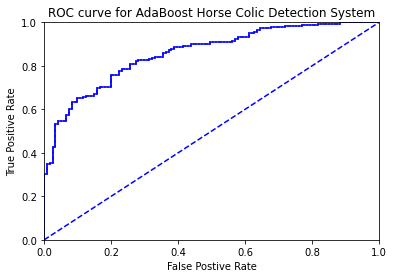

The Area Under the Curve is:  0.8582969635063604


In [159]:
dataArr, labelArr = loadDataSet("horseColicTraining2.txt")
classifierArray, aggClassEst = adaBoostTrainDS(dataArr, labelArr, 10)
plotROC(aggClassEst.T, labelArr)